In [98]:
import xml.etree.ElementTree as ET
import json
import pandas as pd
import datetime
from tqdm import tqdm

from ffmpy3 import FFmpeg #需要先下载ffmpeg可执行文件，然后pip install ffmpy3
from pydub import AudioSegment
from pydub.utils import make_chunks

'''
# import pandas as pd
from minepy import MINE
import os
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号
'''
# 用于分析弹幕情感指数和弹幕的数量
class Danmu():
    def __init__(self, xml_file):
        # 读取XML文件
        self.xml_file = xml_file
        tree = ET.parse(self.xml_file)
        self.root = tree.getroot()
        self.dict_to_json()


    # 定义一个函数来将XML元素转换为字典
    def element_to_dict(self, element):
        result = {}
        if element.attrib:
            result.update(element.attrib)
        for child in element:
            child_data = self.element_to_dict(child)
            if child.tag in result:
                if isinstance(result[child.tag], list):
                    result[child.tag].append(child_data)
                else:
                    result[child.tag] = [result[child.tag], child_data]
            else:
                result[child.tag] = child_data
        if element.text:
            result[element.tag] = element.text
        return result

    # 将XML根元素转换为字典
    def root_to_dict(self):
        self.xml_data = self.element_to_dict(self.root)
        self.xml_data = self.xml_data['d']

    # 将字典转换为JSON
    def dict_to_json(self):
        self.root_to_dict()
        self.json_data = json.dumps(self.xml_data, ensure_ascii=False, indent=2)
        self.json_file = self.xml_file.replace('.xml', '.json')
        with open(self.json_file, 'w', encoding='utf-8') as f:
            f.write(self.json_data)
        # 打印JSON数据
        # print(json_data)

    def my_time(self, timestamp): # 后面会用到
        return datetime.datetime.fromtimestamp(timestamp)
    
    def sentence_emotion_calculate(self):
        df = pd.read_json(self.json_file)

        keep_fields = ['p', 'd'] # d 弹幕内容 p列第五个数据为时间戳 取前10位数字
        df = df[keep_fields]

        df['timestamp'] = df['p'].str.split(',').str[4].str[:10].astype(int)

        df['time'] = df.timestamp.apply(self.my_time)
        df = df[['d', 'time']]

        # 进行简单的情感分析：情感词典打分
        # 下面使用一个台湾的中央研究所开发的情感词典（简体字）
        emo = pd.read_csv('C:\\Users\\杨军\\Desktop\\科研课堂\\dmp-main\\data\\opinion_word_simplified.csv',
                   names = 'word score pos neu neg non not'.split())
        
        # 先使用 正面pos 和 负面 neg
        pos_words = {}
        neg_words = {}

        for item in emo.itertuples():
            if item.pos > 0: pos_words[item.word] = item.pos
            elif item.neg > 0: neg_words[item.word] = item.neg


        pos_score_arr = []
        neg_score_arr = []

        for sentence in tqdm(list(df.d)):
            pos_scores = []
            neg_scores = []
    
            for pos_w, pos_score in pos_words.items():
                if pos_w in sentence: 
                    pos_scores.append(pos_score)
            for neg_w, neg_score in neg_words.items():
                if neg_w in sentence: 
                    neg_scores.append(neg_score)

            pos_score = sum(pos_scores)
            neg_score = sum(neg_scores)

            pos_score_arr.append(pos_score)
            neg_score_arr.append(neg_score)

        df['pos_score'] = pos_score_arr
        df['neg_score'] = neg_score_arr
        
        return df # 方便一点
    
    def my_emotion(self, pos, neg): # 后面会用到
        pos_and_neg = pos+neg
        if(pos_and_neg == 0): return 0.5
        else: return 1.0*pos/pos_and_neg

    def emotion_number_calculate(self, duration = '8s'):
        df = self.sentence_emotion_calculate()
        df.index = df.time
        
        # number
        df1 = df.resample(duration).d.aggregate('count')
        df1.to_csv('D:/myPyVenv/21377222/final/numberOfDanmu.csv', index=True, encoding='utf-8') # 会直接清空在书写

        # 情感指数
        df = df[['pos_score', 'neg_score']].resample(duration).aggregate('sum')
        df['情感指数'] = df.apply(lambda row : self.my_emotion(row['pos_score'], row['neg_score']), axis=1)
        df.to_csv('D:/myPyVenv/21377222/final/danmuemotion.csv', index=True, encoding='utf-8') # 因为 df.index 为时间 故给为 True
        # df['情感指数'].plot(figsize=(9,6))
        # plt.show()

# 用于声音的前期处理，将声音的情感指数计算放在了另一个文件夹内（因为那个里面用的是相对路径，方便一些
class VoiceHandle():
    def __init__(self, filename): # filename 为 .flv 文件
        self.infile = filename
        self.middlefile = self.infile.replace('.flv', '.mp4')
        self.outfile = self.infile.replace('.flv', '.wav')

    def flv_to_video(self):
        ff=FFmpeg(
            inputs={self.infile:None},
            outputs={self.middlefile:[
                    '-ss', str('00:00:00'), #开始时间
                    '-vcodec', 'copy',
                    '-acodec', 'copy'
                ]}
       )
        ff.run()

    def video_to_voice(self):
        ff=FFmpeg(
            executable="D:/ffmpeg-master-latest-win64-gpl-shared/bin/ffmpeg.exe",
            inputs={self.middlefile:None},
            outputs={self.outfile:None}
        )
        ff.run()

    def voice_cut(self, chunk_length_ms=8*1000): # 默认 8s 切割
        self.flv_to_video()
        self.video_to_voice()
        audio = AudioSegment.from_file(self.outfile, '.wav')
        chunks = make_chunks(audio, chunk_length=chunk_length_ms)
        for i, chunk in enumerate(chunks):
            chunk_name = 'D:/yuyin/{}.wav'.format(2*i) # 方便后续读取之后转时间 
            # 一定要去手动清空文件夹！！！！！
            chunk.export(chunk_name, format='wav')

'''
# 用于计算MIC值和弹幕的整合数量占比
class MICNumberCalculate():
    def __init__(self): # 由于我是部分处理的，所以直接将路径放在里面了
        self.mine = MINE(alpha=0.6, c=15)

        self.df1 = pd.read_csv('D:/yuyin/spech-emotion.csv', low_memory=False, encoding='utf-8') # 主播端
        self.df2 = pd.read_csv('D:/myPyVenv/21377222/final/danmuemotion.csv', low_memory=False, encoding='utf-8') # 观众端
        self.df3 = pd.read_csv('D:/myPyVenv/21377222/final/numberOfDanmu.csv', low_memory=False, encoding='utf-8') # 弹幕数量 与 df2 的长度天然一致

        self.df1 = self.df1.sort_values(by='time')

        self.X = self.df1['情感指数'] # 主播端
        self.Y = self.df2['情感指数'] # 观众端
        self.Z = self.df3['d']
        # print(self.X)
        # print(self.Y)
        self.length = min(len(self.X), len(self.Y))
        if(len(self.X) > self.length): self.X = self.X[:self.length]
        if(len(self.Y) > self.length): self.Y = self.Y[:self.length], self.Z = self.Z[:self.length]
        # print(self.X)
        # print(self.Y)

    def mic_number_to_csv(self, number): # number 为数量
        # 计算MIC和弹幕数量
        MIC = []
        Danmu = []
        i = number # 在判断时可以防止越界访问 后续对最后一个数据好操作
        while(i<self.length):
            x = self.X[i-number:i]
            y = self.Y[i-number:i]
            self.mine.compute_score(x, y)
            MIC.append(self.mine.mic())

            Danmu.append(sum(self.Z[i-number:i]))
            i+=number
        x = self.X[i-number:] # 最后一个
        y = self.Y[i-number:]
        self.mine.compute_score(x, y)
        MIC.append(self.mine.mic())
        Danmu.append(sum(self.Z[i-number:]))
        df = pd.DataFrame()
        df['MIC最大互信息系数'] = MIC
        df['弹幕数量'] = Danmu
        total_number = sum(Danmu)
        df['弹幕占比'] = df.apply(lambda row: 1.0*row['弹幕数量']/total_number, axis=1)

        if(os.path.exists('D:/myPyVenv/21377222/final/MICandNumber.csv')):
            df.to_csv('D:/myPyVenv/21377222/final/MICandNumber.csv', mode='a', header=False, index=False, encoding='utf-8') # header 去掉追加的头
        else:
            df.to_csv('D:/myPyVenv/21377222/final/MICandNumber.csv', index=False, encoding='utf-8')
        
        self.mic_number() # 每计算一次都看看图

    def mic_number(self):
        df = pd.read_csv('D:/myPyVenv/21377222/final/MICandNumber.csv', low_memory=False, encoding='utf-8')
        plt.plot(df.index.values, df['MIC最大互信息系数'].values, linestyle='-', label='MIC最大互信息系数', color='b')
        plt.legend(loc='upper left')
        plt.plot(df.index.values, df['弹幕占比'].values, linestyle='--', label='弹幕占比', color='r')
        plt.legend(loc='upper right')
        plt.ylim(0,1)
        plt.figure(figsize=(9,6))
        plt.show()
'''

if __name__ == '__main__':
    path = r'D:\B站\录制视频\30644952-盐盐_ovo际宝冠名版\录制-30644952-20230920-204603-039-会喜欢小盐吗   本直播间由际宝冠名.xml'
    # 每次处理变动 path 就行 .xml 文件
    # 默认 .flv 和 .xml 的前缀一样
    # 由于硬盘内存的原因，我是基于单个处理，如果相基于多个处理
    # 唯一的变动应该是在 VoiceHandle 中切片后文件的存储位置以及后续计算中的位置
    danmu = Danmu(xml_file=path)
    danmu.emotion_number_calculate(duration='8s')
    voicehandle = VoiceHandle(filename=path.replace('.xml', '.flv'))
    voicehandle.voice_cut(chunk_length_ms=8*1000) # 8s
    
    # speech-emotion
    
    # 由于 speech-emotion 中的路径问题，只能将其和后续再单独拿出去
    # micandnumbercalculate = MICNumberCalculate()
    # micandnumbercalculate.mic_number_to_csv(number=40)


100%|██████████| 52/52 [00:00<00:00, 478.33it/s]

# 先去计算 speech-emotion

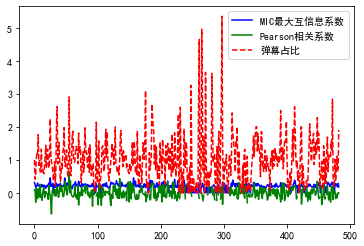

In [99]:
import pandas as pd
from minepy import MINE
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号


# 用于计算MIC值和弹幕的整合数量占比
class MICNumberCalculate():
    def __init__(self): # 由于我是部分处理的，所以直接将路径放在里面了
        self.mine = MINE(alpha=0.6, c=15) # 建议 alpha = 0.68
        
        self.df1 = pd.read_csv('D:/yuyin/speech-emotion.csv', low_memory=False, encoding='utf-8') # 主播端
        self.df2 = pd.read_csv('D:/myPyVenv/21377222/final/danmuemotion.csv', low_memory=False, encoding='utf-8') # 观众端
        self.df3 = pd.read_csv('D:/myPyVenv/21377222/final/numberOfDanmu.csv', low_memory=False, encoding='utf-8') # 弹幕数量 与 df2 的长度天然一致

        self.df1 = self.df1.sort_values(by='time')

        self.X = self.df1['情感指数'] # 主播端
        self.Y = self.df2['情感指数'] # 观众端
        self.Z = self.df3['d']
        # print(self.X)
        # print(self.Y)
    
        self.length = min(len(self.X), len(self.Y))
        
        if(len(self.X) > self.length):
            self.X = self.X[:self.length]
        if(len(self.Y) > self.length):
            self.Y = self.Y[:self.length]
            self.Z = self.Z[:self.length]
        # print(self.X)
        # print(self.Y)

    def mic_number_to_csv(self, number): # number 为数量
        # 计算MIC和弹幕数量
        MIC = []
        
        r = []

        Danmu = []
        i = number # 在判断时可以防止越界访问 后续对最后一个数据好操作
        while(i<self.length):
            x = self.X[i-number:i]
            y = self.Y[i-number:i]
            
            self.mine.compute_score(x, y)
            MIC.append(self.mine.mic())

            r.append(np.corrcoef(x,y)[0,1])

            Danmu.append(sum(self.Z[i-number:i]))
            i+=number
        x = self.X[i-number:] # 最后一个
        y = self.Y[i-number:]
        self.mine.compute_score(x, y)
        MIC.append(self.mine.mic())

        r.append(np.corrcoef(x,y)[0,1])

        Danmu.append(sum(self.Z[i-number:]))
        df = pd.DataFrame()
        df['MIC最大互信息系数'] = MIC

        df['Pearson相关系数'] = r

        df['弹幕数量'] = Danmu
        total_number = sum(Danmu)
        df['弹幕占比'] = df.apply(lambda row: 1.0*self.length*row['弹幕数量']/(total_number*number), axis=1)
        # 平均状态下为 1 看 相对于平均状态其程度
        # 对最后一个数据进行特殊处理
        df.at[df.index[-1], '弹幕占比'] = 1.0*self.length*Danmu[-1]/(total_number*(self.length-i+number))

        if(os.path.exists('D:/myPyVenv/21377222/final/MICandNumber.csv')):
            df.to_csv('D:/myPyVenv/21377222/final/MICandNumber.csv', mode='a', header=False, index=False, encoding='utf-8') # header 去掉追加的头
        else:
            df.to_csv('D:/myPyVenv/21377222/final/MICandNumber.csv', index=False, encoding='utf-8')
        
        self.mic_number() # 每计算一次都看看图

    def mic_number(self):
        df = pd.read_csv('D:/myPyVenv/21377222/final/MICandNumber.csv', low_memory=False, encoding='utf-8')
        fig = plt.figure()
        ax1=fig.subplots()
        ax2=ax1.twinx()

        ax1.plot(df.index.values, df['MIC最大互信息系数'].values, linestyle='-', label='MIC最大互信息系数', color='b')
        
        ax1.plot(df.index.values, df['Pearson相关系数'].values, linestyle='-', label='Pearson相关系数', color='g')
        ax1.legend(loc='upper left')

        ax2.plot(df.index.values, df['弹幕占比'].values, linestyle='--', label='弹幕占比', color='r')

        ax2.legend(loc='upper right')
        plt.show()
        

if __name__ == '__main__':
    micandnumbercalculate = MICNumberCalculate()
    micandnumbercalculate.mic_number_to_csv(number=40)